# EEEN30101 Numerical Analysis

# Week 10

***&copy; 2024 Martínez Ceseña — University of Manchester, UK***

This notebook introduces the following topics:
- Numerical differentiation
- Numerical integration

The use of the notebooks is optional and will not be marked. That said, you are strongly encouraged to play with the tools and examples, as you can explore different variations of the examples, which will better prepare you for the exams.

## List of contents

- [Python code](#Python-code)
- [Numerical differentiation](#Numerical-differentiation)
  - [Comparison with analytical differentiation](#Comparison-with-analytical-differentiation)
  - [Accuracy of numerical differentiation](#Accuracy-of-numerical-differentiation)
  - [Limitations of the floating point representation](#Limitations-of-the-floating-point-representation)
  - [Alternative numerical differentiation approaches](#Alternative-numerical-differentiation-approaches)
- [Numerical integration](#Numerical-integration)
  - [Rectangular (midpoint) rule](#Rectangular-(midpoint)-rule)
  - [Trapezoidal rule](#Trapezoidal-rule)
  - [Simpson's rule](#Simpson's-rule)
  - [Richardson extrapolation](#Richardson-extrapolation)
-[Conclusion](#Conclusion)

## Before we begin

Before we begin: 
- Make sure to review the asynchronous materials provided in blackboard for EEEN30101 Week 10 
- If you have any questions, please post them in the discussion boards or, if that is not possible, send an email to alex.martinezcesena@manchester.ac.uk

This notebook provides some examples in python, for that purpose the following libraries will be loaded:

In [1]:
import math  # To use mathematical operation
import numpy as np  # To define and use matrices
import copy
import matplotlib.pyplot as plt  # To plot figures

try:
    import ipywidgets as widgets
except:
    import micropip
    await micropip.install('ipywidgets')
    import ipywidgets as widgets
from ipywidgets import interact

[Back to top](#EEEN30101-Numerical-Analysis)

## Python code

This notebook requires some algorithms that were developed in previous notebooks, which have been added below. Please review the relevant notebooks for information about these algorithms.

- Methods to model polynomials from the notebooks developed for week 04 ([EEEN30101_Week04](./EEEN30101_Week04.ipynb)):

In [2]:
def polynomial(x=[1], K=[1, 1]):
    '''Simulate value of polynomial'''
    s1 = len(x)
    s2 = len(K)
    y = np.zeros((s1))
    for i in range(s1):
        for j in range(s2):
            y[i] += K[j]*x[i]**j

    return y

def diffPoly(K):
    '''Differentiate polynomial'''
    s = len(K)    
    if s == 1:
        return [0]
    else:
        s -= 1
        dK = np.zeros(s)
        for i in range(s):
            dK[i] = K[i+1]*(i+1)
        return dK

- Methods to plot figures and legends from the notebooks developed for ([EEEN30101_Week04](./EEEN30101_Week04.ipynb)):

In [3]:
def plotFigure(X, Y, Label=[], xlabel='x', ylabel='J(x)', ax=math.nan):
    '''Plot a figure'''
    if ax.__class__ == math.nan.__class__:
        fig, ax = plt.subplots()

    for i in range(X.shape[0]):
        line, = ax.plot(X[i], Y[i], label=Label[i])

    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.grid()
    if '_child' not in line.get_label():
        plt.legend()
    plt.show()

def addPoints(ax, X, Y, Label1, Label2, Dx, Dy):
    '''Add points to figure'''
    mY= min(Y)
    for i in range(len(X)):
        ax.plot(X[i], Y[i], '*')
        ax.text(X[i]-Dx, mY-Dy, Label1[i])
        ax.text(X[i]+Dx, Y[i], Label2[i])

def plotFullFigures(X, Y, Label1, Label2, xlabel='x',
                    ylabel='J(x)', x=[0], y=[0], Label=['']):
    '''Plot a figure with both points and lines'''
    Dx = (max(X)-min(X))*2/100
    Dy = max( (max(Y)-min(Y))*2/10, (np.max(y)-np.min(y))*3/10)
    
    fig, ax = plt.subplots()

    addPoints(ax, X, Y, Label1, Label2, Dx, Dy)

    plotFigure(x, y, Label, xlabel, ylabel, ax)

[Back to top](#EEEN30101-Numerical-Analysis)

## Numerical differentiation

Numerical differentiation, as the name suggests, is a numerical approach to approximate the value of a differential equation at a selected point.

In this section, we will explore the formulation of numerical differentiations compared with their analytical counterpart. We will also explore options to improve the accuracy of numerical differentiation.

### Comparison with analytical differentiation

You should currently be comfortable differentiating equations analytically.

For example, consider the following polynomial function:

$$f(x) = 3x^2$$

In [4]:
def printPoly(K, xt='x'):
    '''Display polynomial'''
    prnt = ''
    for i in range(len(K)):
        if K[i] != 0:
            if K[i]>0:
                prnt += ' + %.4f'%K[i]
            else:
                prnt += ' - %.4f'%(-K[i])
            if i == 1:
                prnt += xt
            elif i > 1:
                prnt += xt+'^%d'%i
    return prnt

K1 = [0, 0, 3]
prnt = printPoly(K1)
print('f(x) = ',prnt)

f(x) =   + 3.0000x^2


You should be able to differentiate this equation to get:
$$f'(x) = \frac{\partial (3x^2)}{\partial x} = 6x$$

In [5]:
prnt = printPoly(diffPoly(K1))
print('f''(x) = ',prnt)

f(x) =   + 6.0000x


The differential of an equation is equivalent to its gradient. 

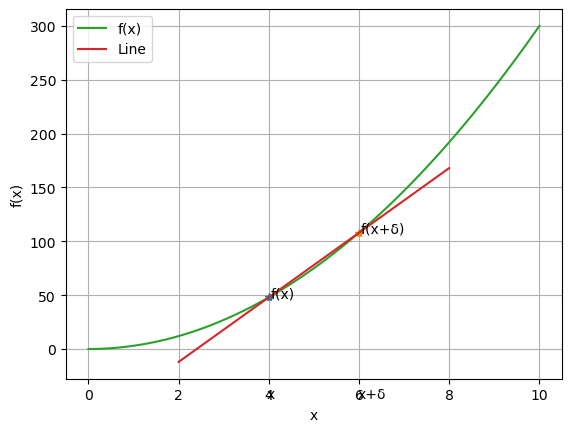

In [6]:
x = np.zeros((2,100))
y = np.ones((2,100))
x[0] = np.linspace(0,10,100)
y[0] = polynomial(x[0], K1)
x[1] = np.linspace(2,8,100)
y[1] = polynomial(x[1], [-72, 30])

X = np.zeros((1,2))
Y = np.zeros((1,2))
X[0] = [4, 6]
Y[0] = polynomial(X[0], K1)

Label1 = ['x', 'x+\u03B4']
Label2 = ['f(x)', 'f(x+\u03B4)']
plotFullFigures(np.transpose(X), np.transpose(Y), Label1, Label2, 'x', 'f(x)', x, y,  ['f(x)', 'Line'])

Accordingly, we could numerically approximate the gradient of the function at a specific point (e.g., $x$), by:
- calculating the value of the function at two locations near that point (e.g., $f(x)$ and $f(x+\delta)$) and
- dividing the difference of those to values ($f(x+\delta) - f(x)$) by the distance between the two points ($\delta$)

$$f'(x) \approx \frac{f(x+\delta) - f(x)}{\delta}$$

To improve the approximate the value of the differential, we can make $\delta$ as small as possible ($\delta \longrightarrow 0$):

$$f'(x) = \lim_{\delta \longrightarrow 0}{\frac{f(x+\delta) - f(x)}{\delta}}$$

If we apply this equation to our example, we get the following:

$$
\begin{aligned}
  \frac{\partial (3x^2)}{\partial x} & = \lim_{\delta \longrightarrow 0}{\frac{3(x+\delta)^2 - 3x^2}{\delta}}  \\
   & = \lim_{\delta \longrightarrow 0}{\frac{3x^2 + 6x\delta + 3\delta^2 - 3x^2}{\delta}} \\
   & = \lim_{\delta \longrightarrow 0}{\frac{6x\delta + 3\delta^2}{\delta}}
\end{aligned}
$$

As we have defined $\delta \longrightarrow 0$, we can argue that: 
- the value of $\delta$ is very low
- the value of $\delta^2$ is even smaller, and it is reasonable to neglect it

Accordingly, our equation can be rewritten as follows:

$$
\begin{aligned}
  f'(x) & = \lim_{\delta \longrightarrow 0}{\frac{6x\delta}{\delta}} \\
  & = \lim_{\delta \longrightarrow 0}{6x} \\
  & = 6x
\end{aligned}
$$

><mark>Numerical differentiation can be used to approximate the value of a differential equation at a point ($x$).</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

Now  that we have shown mathematically that numerical differentiation can provide good estimations of traditional analytical differentiation, let us develop a python class to help us develop an interactive example.

In [7]:
def numDiff(Ex, x, 𝛿=0.0001):
    '''Numerical differentiation'''
    val0 = Ex.get_value(x)
    val1 = Ex.get_value(x+𝛿)

    return (val1-val0)/𝛿
    
class Example1:
    def __init__(self, K=[1, 100]):
        '''Initializing function'''
        self.K = K

    def get_value(self, x):
        '''Get value of the function'''
        return polynomial(x, self.K)

    def get_diff(self, x):
        '''Get differential'''
        return polynomial(x, diffPoly(self.K))
    
    def get_prnt(self, xt='x'):
        return printPoly(self.K, xt)

    def get_prnt2(self, xt='x'):
        return printPoly(diffPoly(self.K), xt)

Compare the analytical and numerical differentiation approaches using the following interactive example:
- Note that the original equation is quadratic ($f(x)=3x^2$). Thus, its differential is a linear equation
- Explore how the accuracy of the calculation changes with different values of $\delta$

In [8]:
@interact
def TestGradient(K1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='K1: ', continuous_update=False),
                 K2 = widgets.FloatSlider(min=-10, max = 10, value=0, description='K2: ', continuous_update=False),
                 K3 = widgets.FloatSlider(min=-10, max = 10, value=3, description='K3: ', continuous_update=False),
                 x = widgets.FloatSlider(min=-10, max = 10, value=5, description='x: ', continuous_update=False),
                 𝛿 = widgets.BoundedFloatText(min=0.000000001, max = 10, value=0.0001, description='𝛿: ',
                                              continuous_update=False)):
    Ex1 = Example1([K1, K2, K3])
    x = np.array([x])

    print('Evaluating the differential of the function: \nf(x) = ',Ex1.get_prnt())
    print('At the point x = %.4f\n'%x[0])

    print('Based on analytical differentiation')
    print('f\'(x) = ',Ex1.get_prnt2(), end=' = ')
    print('%.4f'%Ex1.get_diff(x))

    print('\nBased on numerical differentiation')
    print('f\'(x) = %.4f'%numDiff(Ex1, x, 𝛿))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='K1: ', max=10.0, min=-10.0)…

Let us do one more experiment. 
- This time, the original function will be a linear equation ($f(x)=6x$) and, thus, its differential will be constant
- Explore how the accuracy of the calculation changes with different values of $\delta$

In [9]:
@interact
def TestGradientL(K1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='K1: ', continuous_update=False),
                 K2 = widgets.FloatSlider(min=-10, max = 10, value=6, description='K2: ', continuous_update=False),
                 x = widgets.FloatSlider(min=-10, max = 10, value=5, description='x: ', continuous_update=False),
                 𝛿 = widgets.BoundedFloatText(min=0.000000001, max = 10, value=0.0001, description='𝛿: ',
                                              continuous_update=False)):
    Ex1 = Example1([K1, K2])
    x = np.array([x])

    print('Evaluating the differential of the function: \nf(x) = ',Ex1.get_prnt())
    print('At the point x = %.4f\n'%x[0])

    print('Based on analytical differentiation')
    print('f\'(x) = ',Ex1.get_prnt2(), end=' = ')
    print('%.4f'%Ex1.get_diff(x))

    print('\nBased on numerical differentiation')
    print('f\'(x) = %.4f'%numDiff(Ex1, x, 𝛿))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='K1: ', max=10.0, min=-10.0)…

><mark>The accuracy of a numerical differentiation typically improves as $\delta \longrightarrow 0$ and $\delta \geq 0$.</mark>

><mark>The numerical differentiation of a linear equation is exact, regardless of the value of $\delta$ (as long as $\delta \geq 0).$</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Accuracy of numerical differentiation

Assuming we need to differentiate a nonlinear equation (i.e., the value of $\delta$ matters),
- How good is this approximation?

$$f'(x) \approx \frac{f(x+\delta) - f(x)}{\delta}$$

- How do we choose a value for $\delta$?

To answer these questions, we need to approximate the error associated with the equation for small values of $\delta$.

For this purpose, let us first reformulate the numerical differentiation formula using Taylor's theorem. As a reminder, Taylor's theorem allows us to express an equation as a series of polynomials, which are relatively easy to analyse (see [EEEN30101_Week02](./EEEN30101_Week02.ipynb) notebook).


$$ f(x+\delta) = f(x) + \delta f'(x) + \frac{\delta^2}{2} f'' (\xi) $$

Where $\xi$ is a value within the range that we are using for our numerical differentiation:
$$x \leq \xi \leq x + \delta$$

We can rearrange the terms in the equation the following manner:

$$ f(x+\delta) - f(x) - \frac{\delta^2}{2} f'' (\xi) = \delta f'(x) $$


$$f'(x) = \frac{f(x+\delta) - f(x)}{\delta} + \frac{\delta}{2}f'' (\xi)$$

As a next step, we use big $O$ notation, which is am established  simplified approach to analyse the efficienty of an algorithm.

$$f'(x) = \frac{f(x+h) - f(x)}{\delta} + O(\delta)$$

What this notation means is that, as long as we are using small values of $\delta$, the remainder terms (i.e., the error) denoted by $O(\delta)$ are bounded by a constant value: 

$$O(\delta) \leq \frac{M\delta}{2}$$

To explore the use of this application of the big $O$ notation, you can use the method presented below.

In [10]:
@interact
def TestO(K1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='K1: ', continuous_update=False),
                 K2 = widgets.FloatSlider(min=-10, max = 10, value=0, description='K2: ', continuous_update=False),
                 K3 = widgets.FloatSlider(min=-10, max = 10, value=3, description='K3: ', continuous_update=False),
                 K4 = widgets.FloatSlider(min=-10, max = 10, value=1, description='K4: ', continuous_update=False),
                 x = widgets.FloatSlider(min=-10, max = 10, value=5, description='x: ', continuous_update=False),
                 𝛿 = widgets.BoundedFloatText(min=0.000000001, max = 0.1, value=0.0001, description='𝛿: ',
                                              continuous_update=False)):
    K = [K1, K2, K3, K4]
    Ex1 = Example1(K)
    x = np.array([x])

    print('Evaluating the differential of the function: \nf(x) = ',Ex1.get_prnt())
    print('At the point x = %.4f\n'%x[0])

    print('Based on analytical differentiation')
    print('f\'(x) = ',Ex1.get_prnt2(), end=' = ')
    print('%.4f'%Ex1.get_diff(x))

    print('\nBased on numerical differentiation')
    print('f\'(x) = %.4f'%numDiff(Ex1, x, 𝛿))

    print('\nerror = %.6f'%(numDiff(Ex1, x, 𝛿)-Ex1.get_diff(x)))
    
    Ex2 = Example1(diffPoly(K))
    𝜉 = np.array([x])
    O = 𝛿/2*Ex2.get_diff(𝜉)
    print('\nBased on big O notation, the error is bounded by %.8f:'%O)
    print('i ) Assuming 𝜉=x  , 𝛿/2*f\'\'(x) = %.8f'%(𝛿), end='/2*(')
    print(Ex2.get_prnt2('𝜉'), ') = %.6f'%O)
    
    𝜉 = np.array([x+𝛿])
    print('ii) Assuming 𝜉=x+𝛿, 𝛿/2*f\'\'(x) = %.8f'%(𝛿), end='/2*(')
    print(Ex2.get_prnt2('𝜉'), ') = %.6f'%O)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='K1: ', max=10.0, min=-10.0)…

><mark>This suggests that the approximation gets better as $\delta$ becomes smaller.</mark>

Based on the above, in order to improve the accuracy of our numerical differentiation, it would be convenient to select the smallest $\delta$ that our computers can handle.

[Back to top](#EEEN30101-Numerical-Analysis)

### Limitations of the floating point representation

In practice, we cannot select a value of $\delta$ that is too small due to the accuracy of our computers. That is, we are limited by the approach used by our computers to represent and store floating point numbers.

To illustrate the limitations of the floating point representation, consider the following notation:

  - The true values of our functions will be denoted by $f(x)$ and $f(x+\delta)$, whereas

  - The respective floating point representations of these values would be $\bar{f}(x)$ and $\bar{f}(x+\delta)$

Accordingly, the errors of our floating point represenations can be represented as:

$$|f(x) - \bar{f}(x)| < \epsilon$$

$$|f(x+\delta) - \bar{f}(x+\delta)| < \epsilon$$

If you remember the IEEE double-precision standard from week 03 ([EEEN30101_Week03](./EEEN30101_Week03.ipynb)), we can represent binary fractions using the 52 elements of the mantissa ($m$).

Based on the IEEE standard, the error of our floating point representation is:

$$\epsilon = \left(\frac{1}{2} \right)^{52} = 2^{-53} \approx 10^{-16} $$

Based on the above, the error of a numerical differentiation can be expressed as:

$$ \left| \frac{\bar{f}(x+\delta) - \bar{f}(x)}{\delta} - \frac{f(x+\delta) - f(x)}{\delta}\right| < \frac{2\epsilon}{\delta}$$

Now that we have the error associated with the floating point representation, the total error from both the numerical approximation itself (calculated in the previous section) and the floating point representation is:

$$ \left| f'(x) - \frac{f(x+\delta) - f(x)}{\delta}\right| < \frac{M\delta}{2} + \frac{2\epsilon}{\delta}$$

We can use this equation to estimate the value of $\delta$ that minimises the error of a numerical differentiation, whereas considering the limitations of the floating point estimation.

For this purpose, we will calculate the minimum value of the equation, which is the value of $\delta$ that makes the equation equal to zero as discussed in week 04 ([EEEN30101_Week04 - Part01](./EEEN30101_Week04%20-%20Part01.ipynb) and [EEEN30101_Week04 - Part02](./EEEN30101_Week04%20-%20Part02.ipynb)).

$$ f(\delta) = \frac{M\delta}{2} + \frac{2\epsilon}{\delta}$$

$$ \frac{\partial f(\delta)}{\partial \delta} = \frac{M}{2} - \frac{2\epsilon}{\delta^2}$$

Solving for the optimal value $\delta^*$ when $\partial f(\delta)/\partial \delta = 0$ we get:

$$ 0 = \frac{M}{2} - \frac{2\epsilon}{(\delta^*)^2}$$

$$\frac{M}{2} = \frac{2\epsilon}{(\delta^*)^2}$$

$$(\delta^*)^2 = \frac{4\epsilon}{M}$$

$$\delta^* = 2\sqrt{\frac{\epsilon}{M}}$$

Accordingly, the error of the numerical approximation when the optimal value of $\sigma$ ($\sigma^*$) is used is:

$$
\begin{aligned}
  f(\delta) & = \frac{M}{2}2\sqrt{\frac{\epsilon}{M}} + \frac{2\epsilon}{2\sqrt{\epsilon/M}} \\
  & = M \sqrt{\frac{\epsilon}{M}} + \epsilon \sqrt{\frac{M}{\epsilon}}\\
  & = \sqrt{\epsilon M} + \sqrt{\epsilon M} \\
  & = 2 \sqrt{\epsilon M}
\end{aligned}
$$

[Back to top](#EEEN30101-Numerical-Analysis)

Let us explore these findings with an example:
$$ f(x) = sin(x) $$ 

We will represent this example with a class that includes the function, its derivative and methods to print them.

In [11]:
class Example2:
    def __init__(self):
        '''Initializing function'''

    def get_value(self, x):
        '''Get value of the function'''
        return np.sin(x)

    def get_diff(self, x):
        '''Get differential'''
        return np.cos(x)
    
    def get_prnt(self, xt='x'):
        return 'sin(' + '%.4f'%x[0] + ')'

    def get_prnt2(self, xt='x'):
        return 'cos(' + '%.4f'%x[0] + ')'

Let us now explore the accuracy of the numerical approximation using the method below. Thy using different values for $\delta$.

In [12]:
@interact
def TestND(𝛿 = widgets.BoundedFloatText(min=0.00001, max = 1, value=1,description='𝛿: ', continuous_update=False)):
    Ex2 = Example2()
    T = 100
    a = np.linspace(0, 2*np.pi, T)
    x = np.zeros((2,T))
    y = np.zeros((2,T))

    𝜖 = -1000
    for i in range(T):
        x[0, i] = a[i]
        x[1, i] = a[i]
        y[0, i] = Ex2.get_diff(a[i])
        y[1, i] = numDiff(Ex2, a[i], 𝛿)
        e = np.abs(y[0, i]-y[1, i])
        if e>𝜖:
            𝜖=e

    plotFigure(x, y, ['Analytical','Numerical'], xlabel='x', ylabel='sin(x)')

interactive(children=(BoundedFloatText(value=1.0, description='𝛿: ', max=1.0, min=1e-05), Output()), _dom_clas…

The advantages of using $sin(x)$ as an example are that:
- $-1 \leq f(x) \leq 1$
- $-1 \leq f'(x) \leq 1$
- $-1 \leq f''(x) \leq 1$

As we know that $\epsilon \approx 10^{-16}$:
- $M=1$
- The optimal choice of $\delta$ is $\delta^* = 2x10^{-8}$
- The lowest error is roughly $2x10^{-8}$

If we look at the maximum error associated with the numerical differentiation of $sin(x)$ subject to different values of $\delta$ (see figure below).

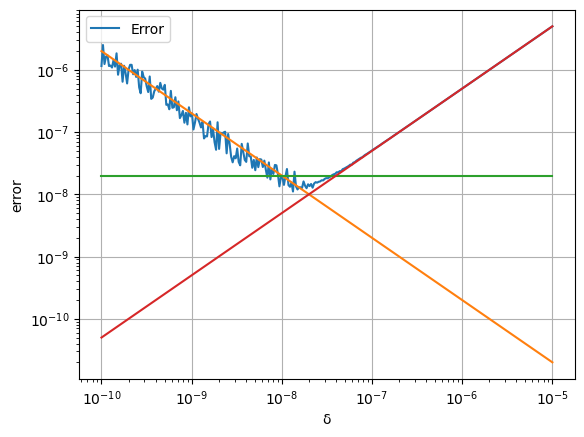

In [13]:
def plotloglog(x, y, L=''):
    fig, ax = plt.subplots()
    ax.loglog(x, y, label=L)
    ax.set(xlabel='\u03B4', ylabel='error')
    ax.grid()
    plt.legend()
    plt.show()

Ex2 = Example2()
T = 300
S = 100
N= 4
a = np.logspace(-10, -5, T)
b = np.linspace(0, np.pi, S)
x = np.zeros((T,N))
y = np.zeros((T,N))
for i in range(T):
    𝛿 = a[i]
    for j in range(N):
        x[i,j] = 𝛿
    y[i,0] = -1000
    for j in range(S):
        e =np.abs(Ex2.get_diff(b[j])-numDiff(Ex2, b[j], 𝛿))
        if e>y[i, 0]:
            if e!=0:
                y[i, 0] = e
    y[i,1] = 10**-16*2/𝛿
    y[i,2] = 2e-8
    y[i,3] = 𝛿/2

plotloglog(x, y, ['Error','','',''])

The simulations show that:
- the error decreases as the value of $\sigma$ drops as the accuracy of the numerical approximation improves, however
- if $\sigma$ becomes too low, the errir increases again due to the accuracy of the computer used for the simulations

[Back to top](#EEEN30101-Numerical-Analysis)

### Alternative numerical differentiation approaches

So far, we have used one numerical approximation approach, namely the forward approximation:

$$f'(x) \approx \frac{f(x+\delta) - f(x)}{\delta}$$

However, there are other options such as:
- Backward appximation

$$f'(x) \approx \frac{f(x) - f(x-\delta)}{\delta}$$

- The mean of the backard and forward approximation

$$f'(x) \approx \frac{f(x+\delta) - f(x-\delta)}{2\delta}$$

These approximations are similar, but can offer different accuracy levels.

Let us explore the mean numerical approximation using Taylor's theorem. 

In [14]:
def numDiffM(Ex, x, 𝛿=0.0001):
    '''Numerical differentiation'''
    val0 = Ex.get_value(x-𝛿)
    val1 = Ex.get_value(x+𝛿)

    return (val1-val0)/𝛿/2

We begin with the first part of the equation $f(x+\delta)$:

$$ f(x+\delta) = f(x) + \delta f'(x) + \frac{\delta^2}{2} f'' (x) + \frac{\delta^3}{6} f''' (\xi_1)$$

For some $x \leq \xi_1 \leq x + \delta$.

A similar analysis can be done for $f(x-\delta)$:

$$ f(x-\delta) = f(x) - \delta f'(x) + \frac{\delta^2}{2} f'' (x) - \frac{\delta^3}{6} f''' (\xi_2)$$

For some $x - \delta\leq \xi_2 \leq x$.

If we get the difference between these equations and, as done at the beginning of this section, solve for $f'(x)$, we get:

$$ f'(x) = \frac{f(x+\delta) - f(x-\delta)}{2\delta} + \frac{\delta^2}{6} \left( f''' (\xi_1) - f''' (\xi_2) \right)$$

Using the big $O$ notation, this equation becomes:

$$ f'(x) = \frac{f(x+\delta) - f(x-\delta)}{2\delta} + O(\delta^2)$$

><mark>The new approximation has $O(\delta^2)$, which is much better than our previous $O(\delta^2)$ for small values of $\delta$.</mark>

As shown in the methods below, this new approach offers a better performance than forward numerical differentiation.
- You can explore the performance of the methods subject to different $\delta$ values

In [15]:
@interact
def TestSin(𝛿 = widgets.BoundedFloatText(min=0.00001, max = 1, value=1,description='𝛿: ', continuous_update=False)):
    Ex2 = Example2()
    T = 100
    a = np.linspace(0, 2*np.pi, T)
    x = np.zeros((3,T))
    y = np.zeros((3,T))

    𝜖 = [-1000, -1000]
    e = [0, 0]
    for i in range(T):
        for j in range(3):
            x[j, i] = a[i]
        y[0, i] = Ex2.get_diff(a[i])
        y[1, i] = numDiff(Ex2, a[i], 𝛿)
        y[2, i] = numDiffM(Ex2, a[i], 𝛿)
        for j in range(2):
            e[j] = np.abs(y[0, i]-y[j+1, i])
            if e[j]>𝜖[j]:
                𝜖[j]=e[j]

    plotFigure(x, y, ['Analytical','Forward','Mean'], xlabel='x', ylabel='sin(x)')

interactive(children=(BoundedFloatText(value=1.0, description='𝛿: ', max=1.0, min=1e-05), Output()), _dom_clas…

A log-log plot of the errora sseociated with these methods is presented below.

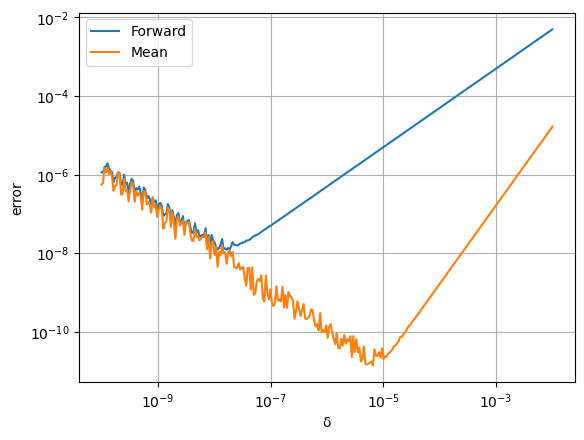

In [16]:
def NDplot(Ex, ND, rng, Lgnd):
    Ex2 = Example2()
    T = 300
    S = 100
    N = len(ND)
    a = np.logspace(rng[0], rng[1], T)
    b = np.linspace(0, np.pi, S)
    x = np.zeros((T,N))
    y = np.zeros((T,N))
    e = np.zeros(N)
    for i in range(T):
        𝛿 = a[i]
        for j in range(N):
            x[i,j] = 𝛿
        for j in range(S):
            for k in range(N):
                e[k] = np.abs(Ex2.get_diff(b[j])-ND[k](Ex2, b[j], 𝛿))
                if e[k]>y[i, k]:
                    if e[k]!=0:
                        y[i, k] = e[k]
    plotloglog(x, y, Lgnd)

NDplot(Example2(),[numDiff, numDiffM], [-10, -2], ['Forward', 'Mean'])

[Back to top](#EEEN30101-Numerical-Analysis)

It is important to note that the performance of the algorithm can be further improved.

For example, as shown above, if the performance of the approximation can be improved by taking the mean of the forward and backward numerical approximation formulas, it makes sense that more advanced approaches to calculate mean values would lead to even better results.

Accordingly, let us take the five-point stencil, which is an estimation based on four points. We will select $f(x+\delta)$, $f(x-\delta)$, $f(x+2\delta)$ and $f(x-2\delta)$.

As before, let us use Taylor's theorem and big $O$ notation.

$$ f(x \pm \delta) = f(x) \pm \delta f' (x) + \frac{\delta^2}{2} f''(x) \pm \frac{h^3}{6} f'''(x) + \frac{h^4}{24}f''''(x) + O(h^5) $$

$$ f(x \pm 2\delta) = f(x) \pm 2\delta f' (x) + \delta^2 f''(x) \pm \frac{4h^3}{3} f'''(x) + \frac{2h^4}{3}f''''(x) + O(h^5) $$

The formulas can be rearranged and simplified as: 
    
$$f(x+\delta) - f(x-\delta) = 2\delta f'(x) + \frac{\delta^3}{3} f'''(x) + O(\delta^5)$$

$$f(x+2\delta) - f(x-2\delta) = 4\delta f'(x) + \frac{8\delta^3}{3} f'''(x) + O(\delta^5)$$

Rearranging the equations and solving for $f'(x)$, we obtain:

$$8[f(x+\delta) - f(x-\delta)] - [f(x+2\delta) - f(x-2\delta)] = 12\delta f'(x) + O(\delta^5)$$


$$ f'(x) = \frac{-f(x+2\delta) + 8 f(x+\delta) - 8 f(x-\delta) + f(x-2\delta)}{12\delta} + O(\delta^5)$$

For convenience, we create a python method with this equation.

In [17]:
def numDiff5(Ex, x, 𝛿=0.0001):
    '''Numerical differentiation'''
    val0 = -Ex.get_value(x+2*𝛿)
    val1 = 8*Ex.get_value(x+𝛿)   #Check
    val2 = -8*Ex.get_value(x-𝛿)
    val3 = Ex.get_value(x-2*𝛿)

    return (val0+val1+val2+val3)/𝛿/12

Test the impacts of the value of $\delta$ on the accuracy of the different numerical differentiation approaches using the method below.

In [18]:
@interact
def TestDel(𝛿 = widgets.BoundedFloatText(min=0.00001, max = 1, value=1,description='𝛿: ', continuous_update=False)):
    Ex2 = Example2()
    T = 100
    a = np.linspace(0, 2*np.pi, T)
    x = np.zeros((4,T))
    y = np.zeros((4,T))

    𝜖 = [-1000, -1000, -1000]
    e = [0, 0, 0]
    for i in range(T):
        for j in range(4):
            x[j, i] = a[i]
        y[0, i] = Ex2.get_diff(a[i])
        y[1, i] = numDiff(Ex2, a[i], 𝛿)
        y[2, i] = numDiffM(Ex2, a[i], 𝛿)
        y[3, i] = numDiff5(Ex2, a[i], 𝛿)
        for j in range(3):
            e[j] = np.abs(y[0, i]-y[j+1, i])
            if e[j]>𝜖[j]:
                𝜖[j]=e[j]

    plotFigure(x, y, ['Analytical','Forward','Mean','5point'], xlabel='x', ylabel='sin(x)')

interactive(children=(BoundedFloatText(value=1.0, description='𝛿: ', max=1.0, min=1e-05), Output()), _dom_clas…

As shown below, this new approach further improves the accuracy of the numerical differentiation.

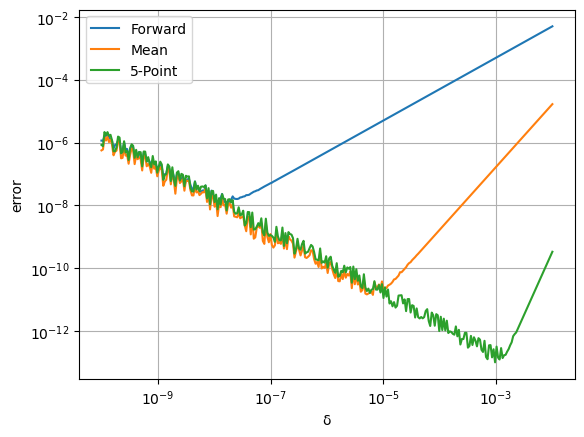

In [19]:
NDplot(Example2(),[numDiff, numDiffM, numDiff5], [-10, -2], ['Forward', 'Mean', '5-Point'])

[Back to top](#EEEN30101-Numerical-Analysis)

## Numerical integration

Numerical integration is an approach to approximate the value of an integral. Thats is, we use numerical integration to answer the following question:

- How can we approximate the value of an integral without explicitly solving it?

$$ \int_a^b f(x)dx \approx ? $$

As a reminder, the integral of a function $f(x)$ within the limits $a$ and $b$ is the area under the curve within that interval.

As an example:

$$ \int_2^8 x^2dx = \frac{1}{3} \left[ x^3 \right]_2^8 = \frac{1}{3} (8^3 - 2^3) = 168$$

In [20]:
def intPoly(K, a, b):
    '''Integrate polynomial'''
    N = len(K)
    ik = np.zeros(N+1)
    for i in range(N):
        ik[i+1] = K[i]/(i+1)
    
    ex = Example1(ik)
    v = ex.get_value([a, b])
    Iv = v[1]-v[0]
    
    return ik, Iv, ex

K = [0, 0, 1]
a = 2
b = 8
Ex1 = Example1(K)
dK, Iv, Ex2 = intPoly(K, a, b)
print('The differential of %s is %s'%(Ex1.get_prnt(), Ex2.get_prnt()))
print('Its value within the range %6.4f - %6.4f is %6.4f'%(a, b, Iv))

The differential of  + 1.0000x^2 is  + 0.3333x^3
Its value within the range 2.0000 - 8.0000 is 168.0000


A figure showing this integral is presented below.

Integral of f(x) =  + 1.0000x^2
In the range 2 - 8


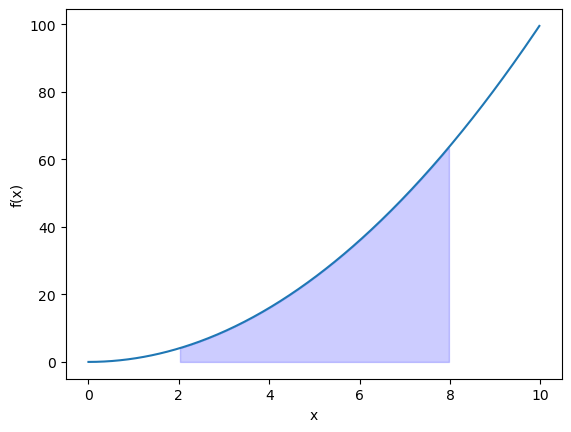

In [21]:
def plotArea(Ex, a, b, rng):
    x = np.arange(rng[0],rng[1],1/40)
    fig, ax = plt.subplots()
    ax.plot(x,Ex.get_value(x))
    ax.fill_between(x= x, y1= Ex.get_value(x), where= (a < x)&(x < b), color= "b", alpha= 0.2)
    ax.set(xlabel='x', ylabel='f(x)')
    print('Integral of f(x) = ' + Ex.get_prnt())
    print('In the range %d - %d'%(a, b))
    return ax 

ax = plotArea(Example1([0, 0, 1]), 2, 8, [0, 10])
plt.show()

><mark>Numerical integration can be used to approximate the area under a function $f(x)$ within two points ($a$ and $b$).</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Rectangular (midpoint) rule

Our first attempt to approximate this area is by dividing this area as a group of rectangles.

Integral of f(x) =  + 1.0000x^2
In the range 2 - 8


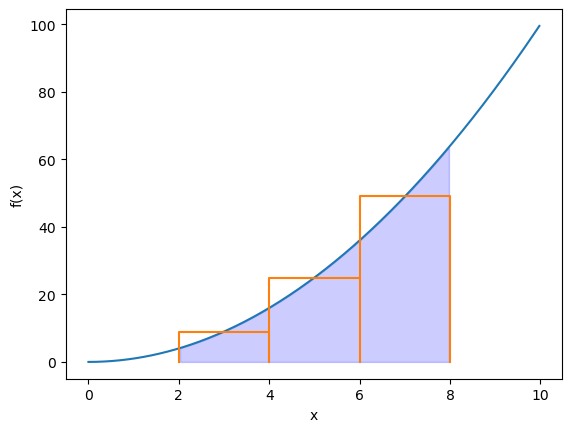

In [22]:
def getMidpoint(Ex, a, b, 𝛿):
    N = int((b-a)/𝛿)
    v = np.zeros(N)
    ar = np.zeros(N)
    for i in range(N):
        v[i] = Ex.get_value([a+(i+0.5)*𝛿])

    for i in range(N):
        ar[i] = v[i]*𝛿

    A = sum(ar)
    return (v, ar, A)

def plotAreaR(Ex, a, b, 𝛿):
    ax = plotArea(Ex, a, b, [0, 10])
    v, _, _ = getMidpoint(Ex, a, b, 𝛿)
    aux = [0, 0, 1, 1, 0]
    j = 0
    x = np.zeros(int(4*(b-a)/𝛿))
    y = np.zeros(int(4*(b-a)/𝛿))
    for i in range(int((b-a)/𝛿)):
        for k in range(4):
            x[j] = a+(i+aux[k])*𝛿
            y[j] = v[i]*aux[k+1]
            j += 1
    ax.plot(x, y)
    plt.show()

Ex = Example1([0, 0, 1])
𝛿 = 2
a = 2
b = 8
plotAreaR(Ex, a, b, 𝛿)

Based on this approximation, the area of each rectangle can be defined as:

$$ A_k = (x_{k+1} - x_{k})f(x_k) = \delta f(x_k)$$

Where:
- $f(x_k)$ is the height of a rectangle, i.e., the value of the function at point $x_k$ which is in the middle of each rectangle
- $\delta$ is the length of the rectanle, i.e, the difference between two consecutive points ($x_k$ and $x_{k+1}$)

Using this formula, the integral can be estimated as the sum of all rectangles within the same range (assume $n$ rectangles fit under the curve).

$$ \int_a^b f(x)dx \approx \sum_{k=0}^{k=n-1} A_k \approx \delta \sum_{k=0}^{k=n-1} f_k$$

In [23]:
def printAreas(Ex, gt, a, b, 𝛿, legend1='Midpoint', legend2='rectangle'):
    v, ar, A = gt(Ex, a, b, 𝛿)
    N = len(ar)
    print('Numerical integration - %s'%legend1)
    print('Area: %.4f'%A)
    print('Number of %ss: %d'%(legend2, N))
    print('Area per %s'%legend2)
    for i in range(N):
        print('%8.4f'%ar[i])

printAreas(Ex, getMidpoint, 2, 8, 2)

Numerical integration - Midpoint
Area: 166.0000
Number of rectangles: 3
Area per rectangle
 18.0000
 50.0000
 98.0000


Based on the big $O$ notation, we can rewrite this equation as follows.

$$ \int_a^b f(x)dx = \delta \sum_{k=0}^{k=n-1} f_k + O(\delta)$$

The term $O(\delta)$ highlights the accuracy of the model, which could be improved.

You may nottice that, an option to improve the accuracy of our approximation is to use more rectanlges (e.g., lower values of $\delta$).

In [24]:
@interact
def TestMid(𝛿 = widgets.BoundedFloatText(min=0.1, max = 1, value=0.5,description='𝛿: ', continuous_update=False)):
    plotAreaR(Example1([0, 0, 1]), 2, 8, 𝛿)
    printAreas(Example1([0, 0, 1]), getMidpoint, 2, 8, 𝛿)

interactive(children=(BoundedFloatText(value=0.5, description='𝛿: ', max=1.0, min=0.1), Output()), _dom_classe…

Decreasing $\delta$ is a good option to improve the accuracy of the algorithm, but we could do better with other approaches, e.g., using other geometrical shapes or curves to approximate the function.

><mark>The rectangular rule consists on approximating the area under a function ($f(x)$) with a series of rectangles.</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Trapezoidal rule

As the name suggests, the trapezoidal rule involves estimating the area under a function (i.e., value of an integral) with a series of trapeziums.

An application of the trapezoidal rule is presented below.

Integral of f(x) =  + 1.0000x^2
In the range 2 - 8


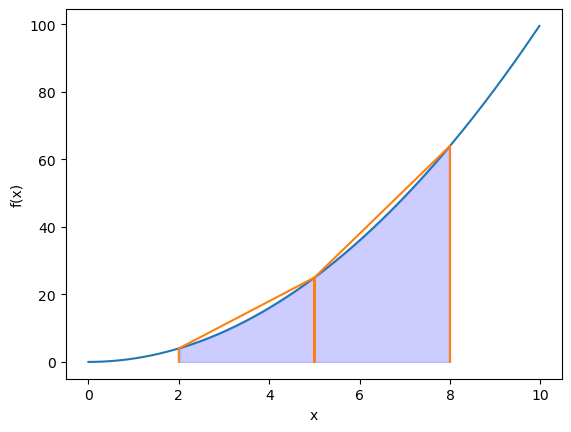

In [25]:
def getTrapezoid(Ex, a, b, 𝛿):
    N = int((b-a)/𝛿)+1
    v = np.zeros(N)
    ar = np.zeros(N-1)
    for i in range(N):
        v[i] = Ex.get_value([a+i*𝛿])

    for i in range(N-1):
        ar[i] = v[i]*𝛿 + (v[i+1]-v[i])*𝛿/2
        
    A = sum(ar)
    return (v, ar, A)

def plotAreaT(Ex, a, b, 𝛿):
    ax = plotArea(Ex, a, b, [0, 10])
    v, _, _ = getTrapezoid(Ex, a, b, 𝛿)
    aux = [0, 0, 1, 1, 0]
    j = 0
    x = np.zeros(int(4*(b-a)/𝛿))
    y = np.zeros(int(4*(b-a)/𝛿))
    for i in range(int((b-a)/𝛿)):
        for k in range(4):
            x[j] = a+(i+aux[k])*𝛿
            y[j] = v[i+aux[k]]*aux[k+1]
            j += 1
    ax.plot(x, y)
    plt.show()

plotAreaT(Example1([0, 0, 1]), 2, 8, 3)

The area of each trapezium can be calculated as the combined area of a rectingle of height $f_k$ and a triangle of height $(f_{k+1}-f_k)$. Both figures have a length of $\delta$ (i.e., $(x_{k+1} - x_{k}$):

$$ A_k = \delta f_k + \delta\frac{f_{k+1}-f_k}{2} = \delta\frac{f_{k+1}+f_k}{2}$$

Using the equation above, the integral can be approximated as the sum of a series of trapeziums. The formula can be simplifed as:

$$
\begin{aligned}
  \int_a^b f(x)dx & = \sum_{k=0}^{k=n-1} A_k \\
  & = \delta \left( \frac{f_0+f_1}{2} +  \frac{f_1+f_2}{2} + \cdots +  \frac{f_{n-2}+f_{n-1}}{2} +  \frac{f_{n-1}+f_n}{2} \right)\\
  & = \delta \left( \frac{f_0}{2} +  \sum_{k=1}^{k=n-1} f_k + \frac{f_n}{2} \right)
\end{aligned}
$$

In [26]:
printAreas(Example1([0, 0, 1]), getTrapezoid, 2, 8, 3, 'Trapezoid', 'trapezium')

Numerical integration - Trapezoid
Area: 177.0000
Number of trapeziums: 2
Area per trapezium
 43.5000
133.5000


In [27]:
def simpTrap(Ex, a, b, 𝛿):
    v, _, _ = getTrapezoid(Ex, a, b, 𝛿)
    N = len(v)
    A = 𝛿*(v[0]/2 + sum(v[1:N-1]) + v[N-1]/2)

    return A

A = simpTrap(Example1([0, 0, 1]), 2, 8, 1)
print('Area according to the formula: %6.4f'%A)

Area according to the formula: 169.0000


It can be shown (using Taylor's expansions and big $O$ notation) that the last equation is equivalent to:

$$ \int_a^b f(x)dx = \delta \left( \frac{f_0}{2} +  \sum_{k=1}^{k=n-1} f_k + \frac{f_n}{2} \right) + O(\delta^2)$$

The error can be calculated as:

$$ \epsilon = \frac{\delta ^2}{12} (b-a) f'' (\xi)$$

For some $a \leq \xi \leq b$.

Note that the error of the trapezoildal rule is smaller ($O(\delta^2)$) than the error of the rectangular rule ($O(\delta)$) for small values of $\delta$.

In [28]:
@interact
def TestTrap(𝛿 = widgets.BoundedFloatText(min=0.1, max = 3, value=0.5,description='𝛿: ', continuous_update=False)):
    plotAreaT(Example1([0, 0, 1]), 2, 8, 𝛿)
    printAreas(Example1([0, 0, 1]), getTrapezoid, 2, 8, 𝛿, 'Trapezoid', 'trapezium')
    A = simpTrap(Example1([0, 0, 1]), 2, 8, 𝛿)
    print('Area according to the formula: %6.4f'%A)

interactive(children=(BoundedFloatText(value=0.5, description='𝛿: ', max=3.0, min=0.1), Output()), _dom_classe…

><mark>The trapezoidal rule consists on approximating the area under a function ($f(x)$) with a series of trapeziums.</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Simpson's rule

So far, we have used rectangles and trapeziums to approximate the value of an integral. This time, based on Simpson's rule, we will use second order polynomials ($p_2(x)$).

Considering that quadratic equations include three parameters ($A + Bx + Cx^2$), three points are needed to fit each equation. See below an example of a quadratic equation fitted to three points:

In [29]:
def fitQuad(x, 𝛿, y):
    '''Fit quadratic equation to inputs'''
    C = (y[0] - 2*y[1] + y[2])/(2*𝛿**2)
    B = (y[2] - y[1] - 2*C*x*𝛿 - C*𝛿**2)/𝛿
    A = y[1] - B*x - C*x**2

    return [A, B, C]

@interact
def TestFit(y1 = widgets.BoundedFloatText(min=-10, max = 10, value=6,description='y1: ', continuous_update=False),
                 y2 = widgets.BoundedFloatText(min=-10, max = 10, value=7,description='y2: ', continuous_update=False),
                 y3 = widgets.BoundedFloatText(min=-10, max = 10, value=4,description='y3: ', continuous_update=False),
                ):
    K = fitQuad(2, 1, [y1, y2, y3])
    P2 = Example1(K)
    print('p2(x) = ' + P2.get_prnt())
    for i in range(3):
        print('p2(%d) = %.4f'%(i+1, P2.get_value([i+1])))

interactive(children=(BoundedFloatText(value=6.0, description='y1: ', max=10.0, min=-10.0), BoundedFloatText(v…

Let us show how the fit looks like in a figure:

Integral of f(x) =  + 1.0000 + 7.0000x - 2.0000x^2
In the range 1 - 3


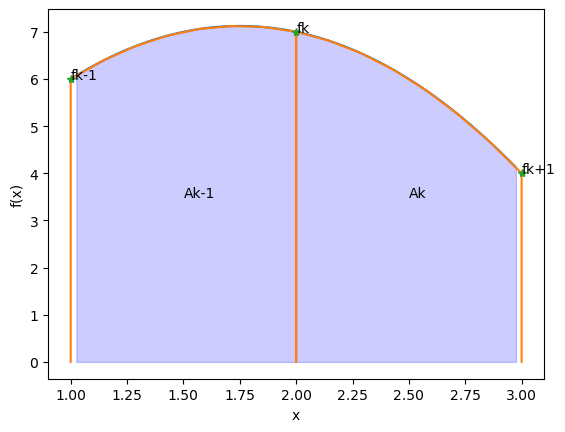

Quadratic curve fit to the points:
[1, 6]
[2, 7]
[3, 4]


In [30]:
def getSimpson(Ex, a, b, 𝛿):
    N = int((b-a)/𝛿/2)
    v = np.zeros((N, 5))
    ar = np.zeros(N)
    k = a+𝛿
    for i in range(N):
        v[i,:3] = fitQuad(k, 𝛿, Ex.get_value([k-𝛿, k, k+𝛿]))
        v[i,3:5] = [k-𝛿, k+𝛿]
        _, ar[i], _ = intPoly(v[i,:3], k-𝛿, k+𝛿)
        k += 2*𝛿

    A = sum(ar)
    return (v, ar, A)

def plotAreaS(Ex, a, b, 𝛿, rng=[1, 10], T=10):
    ax = plotArea(Ex, a, b, rng)
    v, _, _ = getSimpson(Ex, a, b, 𝛿)
    i = 0
    j = 0
    x = np.zeros(int((b-a)/𝛿*T))
    y = np.zeros(int((b-a)/𝛿*T))
    for ii in range(int((b-a)/𝛿/2)):
        K = v[ii, :3]
        P2 = Example1(K)
        for iii in range(2):
            x[j] = a+i*𝛿
            y[j] = 0
            j += 1
            for k in range(T-2):
                x[j] = a + i*𝛿 + k*𝛿/(T-3)
                y[j] = P2.get_value([x[j]])
                j += 1
            x[j] = a+(i+1)*𝛿
            y[j] = 0
            j += 1
            i += 1
    ax.plot(x, y)
    return ax

k = 2
𝛿 = 1
fk = [6, 7, 4]
Ex = Example1(fitQuad(k, 𝛿, fk))
ax = plotAreaS(Ex, k-𝛿, k+𝛿, 𝛿, [1, 3])
ax.plot([k-𝛿, k, k+𝛿], fk, '*')
ax.text(k-𝛿, fk[0], 'fk-1')
ax.text(k, fk[1], 'fk')
ax.text(k+𝛿, fk[2], 'fk+1')
ax.text(k-𝛿/2, fk[1]/2, 'Ak-1')
ax.text(k+𝛿/2, fk[1]/2, 'Ak')
plt.show()

print('Quadratic curve fit to the points:')
print('[%d, %d]'%(k-𝛿, fk[0]))
print('[%d, %d]'%(k, fk[1]))
print('[%d, %d]'%(k+𝛿, fk[2]))

[Back to top](#EEEN30101-Numerical-Analysis)

As shown in the figure above:


$$
p_2(x) =
\left\{ 
  \begin{array}{ c l }
    f_{k-1} & \quad \textrm{when} \; x = x_k - \delta \\
    f_k & \quad \textrm{when} \; x = x_k\\
    f_{k+1} & \quad \textrm{when} \; x = x_k + \delta
  \end{array}
\right.$$

Based on the figure, it can also be seen that the area under the function $p_2(x)$:
- between $x_k-\delta$ and $x_k$ is called $A_{k-1}$ and 
- between $x_k$ and $x_k+\delta$ is called $A_k$

Accordingly, Simpson's rule assumes that the integral of $f(x)$ can be approximated as:

$$ \int_{x_k-\delta}^{x_k+\delta} p_2(x)dx = A_{k-1} + A_{k}$$

Using the same example used in previous sections:

$$ f(x) = x^2$$

Integral of f(x) =  + 1.0000x^2
In the range 2 - 8


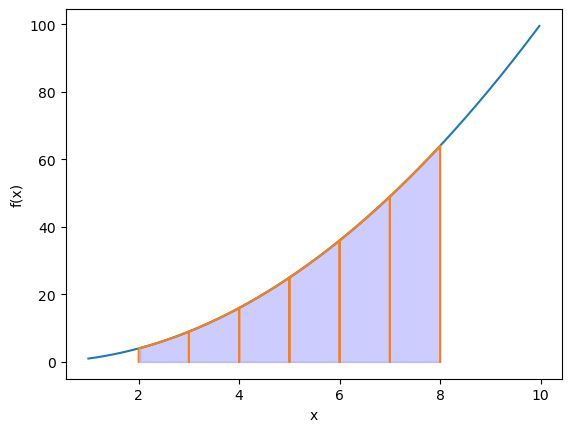

Numerical integration - Simpsons
Area: 168.0000
Number of shapes: 3
Area per shape
 18.6667
 50.6667
 98.6667


In [31]:
ax = plotAreaS(Example1([0, 0, 1]), 2, 8, 1, [1, 10])
plt.show()
printAreas(Example1([0, 0, 1]), getSimpson, 2, 8, 1, 'Simpsons', 'shape')

Conveniently, there is a general approach to fit the quadratic functions $p2(x)$ required to apply Simpson's rule based on the nomenclature we introduced above:

$$
\begin{aligned}
  p_2(x) & = f_{k-1} \frac{(x-x_k)(x-x_k-\delta)}{2\delta^2} + f_k \frac{(x-x_k-\delta)(x-x_k+\delta)}{-\delta^2} + f_{k+1} \frac{(x-x_k)(x-x_k+\delta)}{2\delta^2}\\
  & = \frac{f_{k-1}-2f_k + f_{k+1}}{2\delta^2}(x-x_k)^2 + \frac{f_{k+1}-f_{k-1}}{2\delta}(x-x_k) + f_k
\end{aligned}
$$

Accordingly, we can integrate $p_2(x)$ as follows:

$$
\begin{aligned}
  \int_{x_k-\delta}^{x_k+\delta} p_2(x)dx & = A_{k-1} + A_{k}\\
  & = \int_{x_k-\delta}^{x_k+\delta} \left( \frac{f_{k-1}-2f_k + f_{k+1}}{2\delta^2}(x-x_k)^2 + \frac{f_{k+1}-f_{k-1}}{2\delta}(x-x_k) + f_k \right) dx \\
  & = \int_{-\delta}^{\delta} \left( \frac{f_{k-1}-2f_k + f_{k+1}}{2\delta^2}x^2 + \frac{f_{k+1}-f_{k-1}}{2\delta}x + f_k \right) dx \\
  & = \frac{f_{k-1}-2f_k + f_{k+1}}{2\delta^2} \left[ \frac{1}{3}x^3 \right]^\delta _{-\delta} + \frac{f_{k+1}-f_{k-1}}{2\delta} \left[ \frac{1}{2}x^2 \right]^\delta _{-\delta} + f_k [x]^\delta _{-\delta} \\
  & = \frac{f_{k-1}-2f_k + f_{k+1}}{2\delta^2} \frac{1}{3}\left[ \delta^3 - (-\delta)^3\right] + \frac{f_{k+1}-f_{k-1}}{2\delta} \frac{1}{2}\left[ \delta^2 - (-\delta)^2 \right] + f_k [\delta - (-\delta)] \\
  & = \frac{f_{k-1}-2f_k + f_{k+1}}{2\delta^2} \frac{2 \delta^3}{3} + 0 + 2f_k \delta \\
  & = (f_{k-1}-2f_k + f_{k+1})\frac{\delta}{3} + 2f_k \\
  & = \frac{\delta}{3}f_{k-1} + \frac{4\delta}{3}f_k + \frac{\delta}{3}f_{k+1} \\
  & = \frac{\delta}{3} \left( f_{k-1} + 4f_k + f_{k+1} \right)
\end{aligned}
$$

Now that we can approximate the value of the integral of $f(x)$ within a small range ($x_k - \delta$ to $x_k + \delta$), we can calculate the value for the full range $a$ to $b$ as follows:

$$
\begin{aligned}
  \int_{a}^{b} f(x)dx & = (A_0 + A_1) + (A_2 + A_3) + \cdots + (A_{n-2} + A_{n-1})\\
  & =  \frac{\delta}{3} \left[ (f_0 + 4f_1 + f_2) + (f_2 + 4f_3 + f_4) + \cdots + (f_{n-2} + 4f_{n-1} + f_n) \right] \\
  & =  \frac{\delta}{3} \left[ f_0 + f_n + 4 \sum _{k \; even}f_k + 2 \sum _{k \; odd}f_k \right]
\end{aligned}
$$


Note that, as we need 3 points to fit the quadratic curves, we need $n$ to be an even number for this approximation.

In [32]:
def simpSimp(Ex, a, b, 𝛿):
    v, _, _ = getTrapezoid(Ex, a, b, 𝛿)
    N = len(v)
    w = v[1:N-1]
    A = 𝛿/3*(v[0] + v[N-1] + 4*sum(w[0::2]) + 2*sum(w[1::2]))

    return A

A = simpSimp(Example1([0, 0, 1]), 2, 8, 0.5)
print('Area according to the formula: %6.4f'%A)

Area according to the formula: 168.0000


If we were to explore the equation (e.g., using Taylor's theorem and big $O$ notation), we would find out that the approximation is $O(h^4)$, and the error is:

$$ \epsilon = \frac{\delta^4}{180}(b-a)f''''(\xi) $$

For some $a \leq \xi \leq b$

In [33]:
@interact
def TestSimp(𝛿 = widgets.BoundedFloatText(min=0.1, max = 3, value=0.5,description='𝛿: ', continuous_update=False)):
    ax = plotAreaS(Example1([0, 0, 1]), 2, 8, 𝛿, [1, 10])
    plt.show()
    printAreas(Example1([0, 0, 1]), getSimpson, 2, 8, 𝛿, 'Simpsons', 'shape')
    A = simpSimp(Example1([0, 0, 1]), 2, 8, 0.5)
    print('Area according to the formula: %6.4f'%A)

interactive(children=(BoundedFloatText(value=0.5, description='𝛿: ', max=3.0, min=0.1), Output()), _dom_classe…

><mark>Simpson's rule consists on approximating a function ($f(x)$) with a series of quadratic functions ($p_2$) which are easy to integrate.</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Richardson extrapolation

In addition to the numerical integration methods presented above, there are many other approaches that can be used for numerical integration. Some of these approaches use mathematical tricks to better approximate the areas under the functions $f$ such as Richardson extrapolation.

Richardson extrapolation is a method that can be used to reduce the error of an approximation (as long as the order of the error is known).

For example, this method can be used to improve the trapezoidal rule (linear approximation of $f(x)$) to produce Simpson's rule (quadratic approximation of $f(x)$).

Let us begin with a representation of the trapezoidal rule and its error:

$$
\begin{aligned}
  \int_{a}^{b} f(x)dx  & = \underbrace{\quad I_T(\delta) \quad} & + \quad \underbrace{\epsilon_T(\delta)}\\
   & \quad \text{Trapezoidal} & \quad \text{Error}
\end{aligned}
$$

We can replace $I_T(\delta)$ and $E_T(\delta)$ with their corresponding formulas. Remember that we developed these formulats in previous sections of this notebook.

$$ I_T(\delta) = \delta \left[ \frac{f(a)}{2} + f(a+\delta) + \cdots + f(b-\delta) + \frac{f(b)}{2} \right] $$

$$ \epsilon_T(\delta) = \frac{-(b-a)^2}{12} \delta^2 f''(\xi) $$

For some $a \leq \xi \leq b$

We will apply these equations with two different small values of $\delta$, namely $\delta_1$ and $\delta_2$.

$$ \int_{a}^{b} f(x)dx = I_T(\delta_1) + \epsilon_T(\delta_1) = I_T(\delta_2) + \epsilon_T(\delta_2)$$

The equations can be solved to obtain the ratio of their expected errors. Also, it is assumed that $f''(\xi_1)/f''(\xi_2) \approx 1$.

$$
\begin{aligned}
  \frac{\epsilon_T(\delta_1)}{\epsilon_T(\delta_2)} & = \frac{\delta_1^2 f''(\xi_1)}{\delta_2^2 f''(\xi_2)} with 
\left\{ 
  \begin{array}{ l }
    a \leq \xi_1 \leq b \\
    a \leq \xi_2 \leq b
  \end{array}
\right. \\
  & \approx \frac{\delta _1^2}{\delta _2^2}
\end{aligned}
$$

If we subsitute the approximated error ratio, we get:

$$I_T(\delta_1) + \frac{\delta^2_1}{\delta^2_2}\epsilon_T{\delta_2} \approx I_T(\delta_2) + \epsilon_T(\delta_2) $$

Solving for $\epsilon _T(\delta_2)$:

$$ \epsilon_T(\delta_2) \approx \frac{I_T(\delta_1) - I_T(\delta_2)}{1 - \delta_1^2/\delta_2^2} $$

Substituting the new $\epsilon _T(\delta_2)$ equation:

$$
\begin{aligned}
  \int_{a}^{b} f(x)dx & = I_T(\delta_2) + \epsilon_T(\delta_2)\\
  & \approx I_T(\delta_2) + \frac{I_T(\delta_1) - I_T(\delta_2)}{1 - \delta_1^2/\delta_2^2} \\
  & =  \frac{\delta_2^2 I_T(\delta_1) - \delta_1^2 I_T(\delta_2)}{\delta_2^2-\delta_1^2}
\end{aligned}
$$

To solve this equation, we need to make assumptions about $\delta_1$ and $\delta_2$. Consider that $\delta_2$ is half the length of $\delta_1$.

$$ \delta_2 = \frac{\delta_1}{2}$$

Accordingly, the equation becomes:

$$
\begin{aligned}
  \int_{a}^{b} f(x)dx & = \frac{\delta_1^2 I_T(\delta_1)/4 - \delta_1^2 I_T(\delta_2)}{\delta_1^2/4 -\delta_1^2}\\
  & = \frac{4}{3}I_T(\delta_2) - \frac{1}{3}I_T(\delta_1) \\
  & = \frac{4}{3}\delta_2 \left[ \frac{f(a)}{2} + f(a + \delta_2) + \cdots + f(b - \delta_2) + \frac{f(b)}{2} \right] - \frac{1}{3}(2\delta_2) \left[ \frac{f(a)}{2} + f(a + 2\delta_2) + \cdots + f(b - 2\delta_2) + \frac{f(b)}{2} \right] \\
  & = \frac{\delta_2}{3} \left[ f(a) + 4f(a+\delta_2) + 2f(a+2\delta_2) + \cdots + 2f(b-2\delta_2) + 2f(b-\delta_2) + f(b)\right]
\end{aligned}
$$

This last equation is Simpson's rule. Thats is, we have shown that Richardson extrapolation can be applied to the trapezoidal rule to develop Simson's rule.

[Back to top](#EEEN30101-Numerical-Analysis)

## Conclusion

At the end of this week's lecture and after going through this notebook, you should be able to address the following questions:<br/>
- Numerical differentiation: <br/>
      - What is numerical differentiation?<br/>
      - How can the backward numerical differentiation be applied?<br/>
      - How can the forward numerical differentiation be applied?<br/>
      - How can the numerical differentiation be improved using mean values and the 5-point stencil?<br/><br/>
- Numerical integration: <br/>
      - What is numerical integration?<br/>
      - How can the rectangular rule be applied?<br/>
      - How can the trapezoidal rule be applied?<br/>
      - How can Simpson's rule be applied?

If you cannot answer these questions, you may want to check again this notebook and the lecture notes.

[Back to top](#EEEN30101-Numerical-Analysis)